# GPR

In GPR the Kernel defines a covariance matrix between a set of points in a space.

The most common kernel is the radial basis function RBF kernel, also known as exponential kernel or gaussian kernel.

$$K_{ij} = \sigma^2 \exp\left( - \frac{(x_i - x_j)²}{2 l²}  \right)$$

# Interpreting Lengthscale $l$, smoothness
$l$ defines the covariance between a point in space $x_i$ and another $x_j$, if $l$ is high then the points $x_i$ and $x_j$ will have a high covaraince even if they are far away, this means they are correlated and the predicted $y$ has to be similar for them both. This means the prediction will be smooth. The inverse argumnent is true for $l$ is small.

# Interpreting Sigma $\sigma$, amplitude
It is sometimes called the amplitude or just variance. It defines the variance of points with themselves. If $x_i = x_j$ then $K_ij = sigma²$. This defines the probability the fit can leave the prior mean. GPR is inheriently derived form bayesian stastics and thus has a prior. The prior mean is our guess of the function values at each point x. Usually it is set to 0 and said to be uninformative. $\sigma$ defines how likely it is for the fit to stray from the prior, so if we are confident about our prior we can set this to 0, if we are not sure we can set $\sigma$ to be large. A good rule of thumb is to set it to the order of magnitude of the $y$ values in the data.



# Over Fitting LENGTHSCALE and using it as a measure of smoothness, DIDN'T WORK

The idea here is that if we overfit to the data with mean square error fit then the lengthscale selected could represent the smoothness of the function.

This method was not optimal as when there is soo much data the optimal lengthscale is the same for the smooth and non smooth function which is on the order of a few x seperations. So rather than optimising to find the same point every time it makes more sence to choose a lengthscale or smoothness and see how well it fits to function. If we assume its smooth and GPR fits well then we know it is smooth; if it doesn't fit well then we know it is not smooth. 

In [2]:
from GPy.models import GPRegression
from GPy.kern import RBF
import numpy as np
import matplotlib.pyplot as plt

# Simulated Data

DELTA X 0.020978915883738184


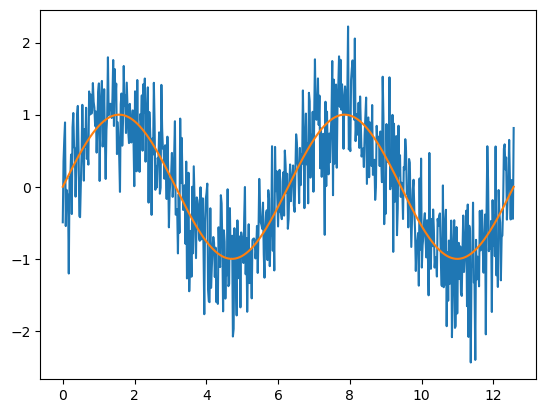

In [3]:
import matplotlib.pyplot as plt
import numpy as np


n_points = 600
x = np.linspace(0, 4*np.pi, n_points)
delta_x = np.mean(x[1:] - np.roll(x, 1)[1:])
print('DELTA X', delta_x)
y = np.sin(x)
noise = np.random.normal(0,0.5, n_points)
y_noisy =y + noise


plt.plot(x,y_noisy)
plt.plot(x,y)

In [33]:
def MSE(x, y, lengthscale_dx, plot=True):
    lengthscale_dx = np.array(lengthscale_dx)
    delta_x = np.mean(x[1:] - np.roll(x, 1)[1:])
    lengthscale = lengthscale_dx * delta_x
    mse = []
    for l, l_dx in zip(lengthscale, lengthscale_dx):
        kernel = RBF(input_dim=1, variance=2, lengthscale=l)

        regressor = GPRegression(np.array(x)[:,None], np.array(y)[:,None], kernel, noise_var=0)
            
        pred, error = regressor.predict(np.array(x)[:,None])
        pred = pred.flatten()
        error = error.flatten()
        
        mse.append(np.mean((y - pred)**2))
        if plot and (l == lengthscale[0] or l==lengthscale[-1]):
            plt.figure()
            plt.plot(x,y, '.', label = 'Data')
            plt.plot(x,pred, label='Prediction')
            plt.title(f'Lengthscale = {l_dx} $\\Delta x$ | MSE = {np.format_float_scientific(mse[-1], 3)}')
            plt.legend()
            # plt.fill_between(x, pred-(error**2), pred+(error**2), color = (1,1,0,0.2))
    return mse

lengthscale_dx = np.arange(1,500,10)
        

# Assume some large lengthscale (smoothness degree), that we know works well for the smooth function and will not fit well to the noisy function, then the noisy functions can be detected by a large mean squared error.

We are saying 350 $\Delta x$

 # Determine the large lengthscale that works well for smooth and not well for noisy,

We can do this by taking a few of our known to be smooth functions and plotting the meas square error as a function of lengthscale in units of delta x then selecting the lengthscale just before the mse shoots up.

Looking at the plots below lets say **350 $\Delta x$**. It doesn't matter too much if this value isn't optimised. 

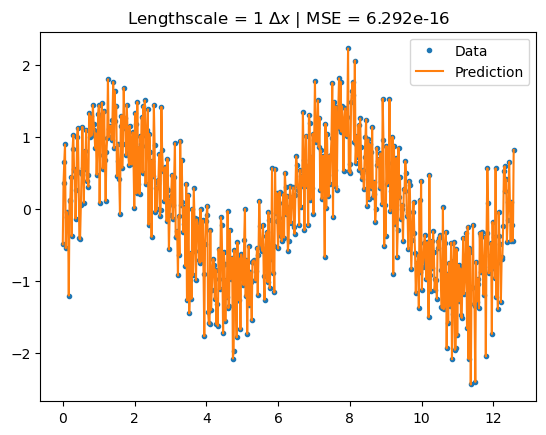

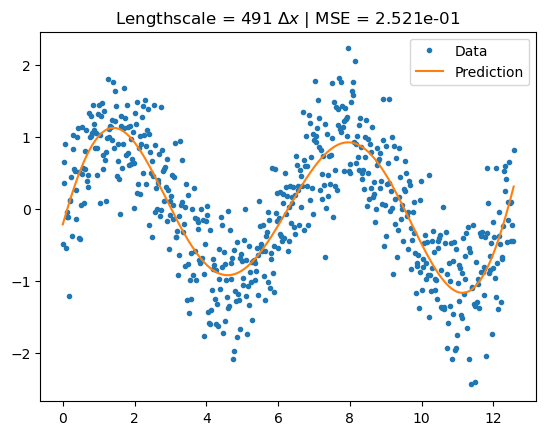

In [27]:
mse_n = MSE(x, y_noisy, lengthscale_dx, plot=True)

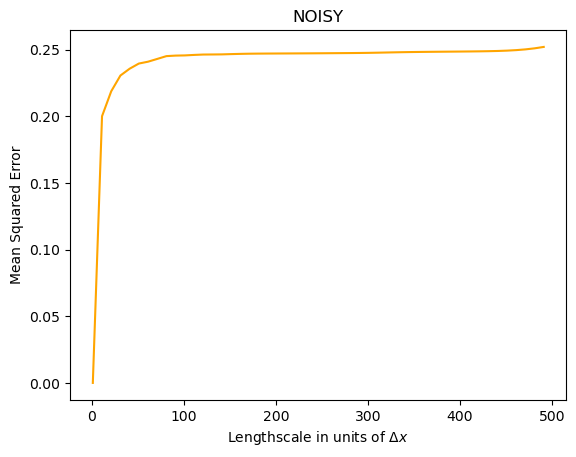

In [28]:
plt.figure()
plt.plot(lengthscale_dx, mse_n, color='orange')
plt.xlabel(r'Lengthscale in units of $\Delta x$')
plt.ylabel('Mean Squared Error')
plt.title('NOISY')
plt.show()

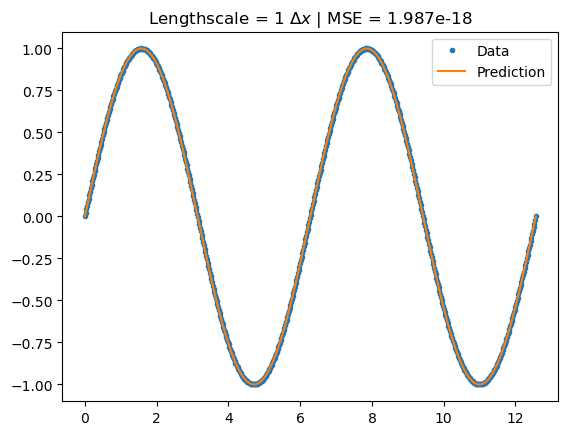

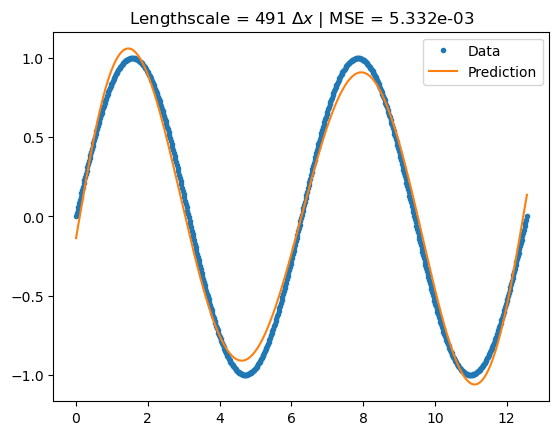

In [17]:
mse_s = MSE(multiples, x, y, plot=True)

Text(0, 0.5, 'Mean Squared Error')

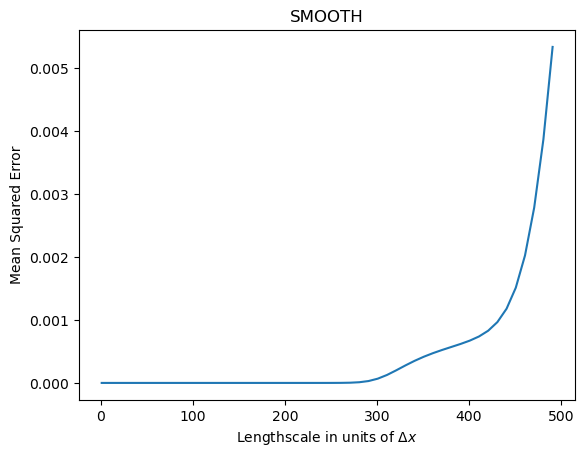

In [29]:
plt.figure()
plt.plot(lengthscale_dx, mse_s)
plt.title('SMOOTH')
plt.xlabel(r'Lengthscale in units of $\Delta x$')
plt.ylabel('Mean Squared Error')

Text(0.5, 1.0, 'COMPARISON')

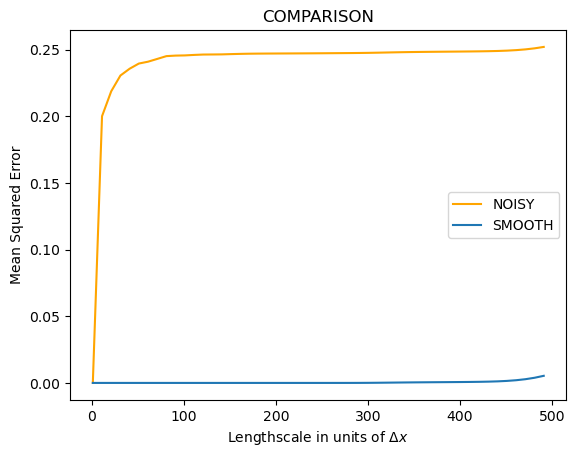

In [30]:
plt.figure()
plt.plot(lengthscale_dx, mse_n, color='orange', label='NOISY')
plt.plot(lengthscale_dx, mse_s, label='SMOOTH')
plt.legend()
plt.xlabel(r'Lengthscale in units of $\Delta x$')
plt.ylabel('Mean Squared Error')
plt.title('COMPARISON')

# We see why over fitting lengthscale with mse won't work because they will both go to 0 wether it is smooth or not. This is because we have a lot of data. 


# However for any lengthscale above 100 $\Delta x$ there is a large discrepancy between means square error for noisy and smooth functions and this can be used to categorise them.

Is y_noise noisy? True
Is y noisy? False


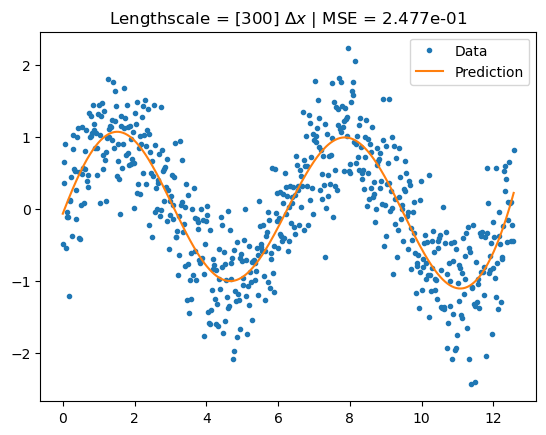

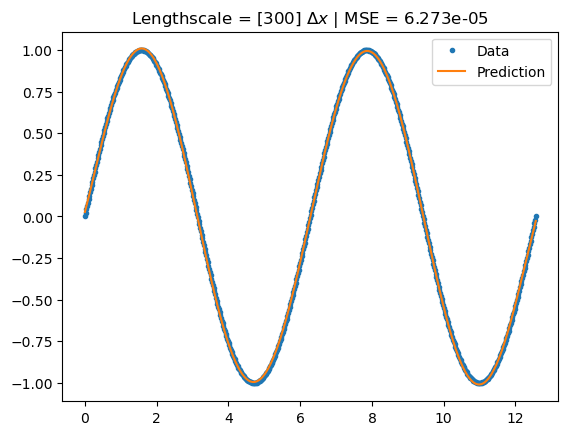

In [36]:
def noise_detector(x, y, smoothness_lengthscale_dx_assumption, mse_threshold):
    mse = MSE(x,y, lengthscale_dx=[smoothness_lengthscale_dx_assumption])[-1]
    if mse > mse_threshold:
        return True
    if mse < mse_threshold:
        return False
    if mse == mse_threshold:
        return None
    
print('Is y_noise noisy?', noise_detector(x, y_noisy, smoothness_lengthscale_dx_assumption=[300], mse_threshold=0.05))

print('Is y noisy?', noise_detector(x, y, smoothness_lengthscale_dx_assumption=[300], mse_threshold=0.05))
    

# Now you have two parameters to Tune in order to get the best confusion matrix with your data points on numerical instabilities.

You can potentially optimise these parameters with scipy.optimise and give negative % accuracy as a function to minimise. 